# Career Skill - Reddit Text Analytics Project

This notebook is focused on:
- career uncertainty themes,
- job desirability framing (hard vs soft skill orientation), and
- community response patterns.

## Run Order
1. Run Section 0 setup cells first.
2. Run sections sequentially from 1 to 15.
3. Review saved outputs in `artifacts_refined/` and `figures/`.

```bash
pip install pandas numpy scikit-learn nltk spacy scipy joblib matplotlib seaborn vaderSentiment pyarrow
```


## 0) Setup & Imports

Library purposes:
- `pandas`, `numpy`: data wrangling and numerical operations
- `scikit-learn`, `scipy`: vectorization, clustering, dimensionality reduction, sparse feature stacking
- `nltk` (POS + VADER): linguistic preprocessing and sentiment
- `joblib`: model persistence
- `matplotlib`, `seaborn`: stakeholder-facing visualization
- `spacy` (optional install cell): alternative NLP pipeline support


In [1]:
# Install missing libraries (safe no-op when already installed)
import importlib
import subprocess
import sys

required = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'nltk': 'nltk',
    'scipy': 'scipy',
    'joblib': 'joblib',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'vaderSentiment': 'vaderSentiment',
    'spacy': 'spacy',
    'pyarrow': 'pyarrow',
}

missing = []
for mod, pkg in required.items():
    try:
        importlib.import_module(mod)
    except Exception:
        missing.append(pkg)

if missing:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + missing)
    print('Installed:', missing)
else:
    print('All required libraries already installed.')


All required libraries already installed.


In [2]:
# Download NLP resources/models
import nltk
import subprocess
import sys

for res in ['stopwords', 'punkt', 'wordnet', 'omw-1.4', 'vader_lexicon', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    try:
        nltk.download(res, quiet=True)
    except Exception:
        pass

# Optional spaCy model download (not required if using NLTK POS)
try:
    import spacy
    try:
        spacy.load('en_core_web_sm')
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])
except Exception:
    pass

print('NLP resources ready.')


NLP resources ready.


In [3]:
import os
import re
import json
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.preprocessing import MaxAbsScaler

import joblib

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
DATA_BASE = DATA_DIR if DATA_DIR.exists() else PROJECT_ROOT
ART = PROJECT_ROOT / 'artifacts_refined'
FIG = PROJECT_ROOT / 'figures'
ART.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
SIA = SentimentIntensityAnalyzer()

print('Project root:', PROJECT_ROOT)
print('Data source:', DATA_BASE)


Project root: /home/frondy/code/project/Text Analytic
Data source: /home/frondy/code/project/Text Analytic


## 1) Methodology

# Methodology

### 1.1 Research Objective
This project analyzes Reddit career discussions to uncover how uncertainty is structured in data analytics discourse and how job desirability is framed through hard-skill versus soft-skill signals.

### 1.2 Constructs Defined
- **Career Uncertainty Themes**: identified via clustering over concept-enriched document representations.
- **Job Desirability Framing**: operationalized using weighted phrase lexicons (hard vs soft emphasis) derived from PMI orientation.
- **Community Response Patterns**: measured through sentiment differences (post vs comment) and engagement indicators (comment counts).

### 1.3 Lexicon Development Rationale
We extract linguistically meaningful phrases (ADJ+NOUN, ADV+ADJ, NOUN+NOUN), then compute PMI between candidate phrases and hard/soft seed lexicons using Turney-style semantic orientation. Orientation is defined as `PMI(phrase,HARD) - PMI(phrase,SOFT)`. Positive orientation contributes to hard-skill framing; negative orientation contributes to soft-skill framing. Lexicon weights represent association strength in this corpus, not causal effects.

### 1.4 Clustering Strategy & Validation Criteria
We apply domain stop-word filtering and TF-IDF tuning, then append normalized lexicon features to text vectors for concept-driven clustering. We evaluate `k=4..12` using silhouette, cluster balance, and interpretability diagnostics before selecting the final model.

### 1.5 Outputs for Stakeholders
Expected outputs include cluster profiles, top TF-IDF terms and PMI phrases, sentiment and engagement comparisons, difference-from-mean diagnostics, and concise interpretation statements describing what each cluster suggests.


## 2) Load & Merge Data

In [4]:
def parse_subreddit(path: Path) -> str:
    m = re.match(r'reddit_(.+?)_(1000_posts|top_10_comments)_', path.name)
    return m.group(1) if m else 'unknown'

def std_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [c.strip().lower() for c in out.columns]
    return out

def pick(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

post_files = sorted(DATA_BASE.glob('reddit_*_1000_posts_*.csv'))
comment_files = sorted(DATA_BASE.glob('reddit_*_top_10_comments_*.csv'))
assert post_files, 'No post files found.'
assert comment_files, 'No comment files found.'

post_frames = []
for f in post_files:
    p = std_cols(pd.read_csv(f))
    p['subreddit'] = parse_subreddit(f)
    id_col = pick(p, ['post_id','id','submission_id'])
    title_col = pick(p, ['title','post_title'])
    body_col = pick(p, ['body','selftext','text','post_body'])
    if id_col is None:
        raise ValueError(f'missing post id in {f.name}')

    p['post_id'] = p[id_col].astype(str)
    p['title_std'] = p[title_col].fillna('').astype(str) if title_col else ''
    p['body_std'] = p[body_col].fillna('').astype(str) if body_col else ''
    p['post_text'] = (p['title_std'] + ' ' + p['body_std']).str.strip()

    keep = ['post_id','subreddit','title_std','body_std','post_text']
    for c in ['score','num_comments','created_utc','url']:
        if c in p.columns:
            keep.append(c)
    post_frames.append(p[keep])

df_posts = pd.concat(post_frames, ignore_index=True).drop_duplicates(subset=['post_id','subreddit'])

comment_frames = []
for f in comment_files:
    c = std_cols(pd.read_csv(f))
    c['subreddit'] = parse_subreddit(f)
    id_col = pick(c, ['post_id','submission_id','id'])
    rank_col = pick(c, ['comment_rank','rank'])
    body_col = pick(c, ['comment_body','body','text'])
    score_col = pick(c, ['comment_score','score'])
    if id_col is None or body_col is None:
        raise ValueError(f'missing comment fields in {f.name}')

    c['post_id'] = c[id_col].astype(str)
    c['comment_rank_std'] = pd.to_numeric(c[rank_col], errors='coerce') if rank_col else np.nan
    c['comment_body_std'] = c[body_col].fillna('').astype(str)
    c['comment_score_std'] = pd.to_numeric(c[score_col], errors='coerce') if score_col else np.nan
    comment_frames.append(c[['post_id','subreddit','comment_rank_std','comment_body_std','comment_score_std']])

df_comments = pd.concat(comment_frames, ignore_index=True)
df_comments = df_comments.sort_values(['post_id','comment_rank_std'], kind='stable')

agg_comments = df_comments.groupby('post_id', as_index=False).agg(
    comments_text=('comment_body_std', lambda s: ' '.join(s.astype(str).tolist())),
    comments_count_observed=('comment_body_std', 'size'),
    avg_comment_score=('comment_score_std', 'mean')
)

df = df_posts.merge(agg_comments, on='post_id', how='left')
df['comments_text'] = df['comments_text'].fillna('')
df['comments_count_observed'] = df['comments_count_observed'].fillna(0).astype(int)

print('df_posts:', df_posts.shape, 'df_comments:', df_comments.shape, 'merged df:', df.shape)
print('duplicates in merged post_id:', df.duplicated(subset=['post_id']).sum())
print('missing rates:')
print(df[['post_id','post_text','comments_text']].isna().mean())
df.head(2)


df_posts: (1135, 9) df_comments: (4704, 5) merged df: (1135, 12)
duplicates in merged post_id: 0
missing rates:
post_id          0.0
post_text        0.0
comments_text    0.0
dtype: float64


,post_id,subreddit,title_std,body_std,post_text,score,num_comments,created_utc,url,comments_text,comments_count_observed,avg_comment_score
0,1qx2vvc,analytics,Information systems or business analytics?,"Hi, I am a first year information systems majo...","Information systems or business analytics? Hi,...",1,2,1.770338e+09,https://www.reddit.com/r/analytics/comments/1q...,If this post doesn't follow the rules or isn't...,2,1.0
1,1qx1m80,analytics,Most DA portfolios are ignored for one reason ...,Rule: if a hiring manager can't point to a job...,Most DA portfolios are ignored for one reason ...,0,2,1.770335e+09,https://www.reddit.com/r/analytics/comments/1q...,If this post doesn't follow the rules or isn't...,1,1.0


## 3) Text Preprocessing

In [5]:
TOKEN_RE = re.compile(r"[a-zA-Z][a-zA-Z0-9']+")

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = ''
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r"[^a-z0-9\s']", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess(text: str, stopset) -> str:
    txt = clean_text(text)
    toks = TOKEN_RE.findall(txt)
    lem = [LEMMATIZER.lemmatize(t) for t in toks]
    lem = [t for t in lem if t not in stopset and len(t) > 2]
    return ' '.join(lem)

# initial clean text (before domain-stopword refinement)
df['post_text_clean_base'] = df['post_text'].map(lambda x: preprocess(x, STOP_WORDS))
df['comments_text_clean'] = df['comments_text'].map(lambda x: preprocess(x, STOP_WORDS))

df[['post_text_clean_base','comments_text_clean']].head(2)


,post_text_clean_base,comments_text_clean
0,information system business analytics first ye...,post follow rule flaired correctly please repo...
1,portfolio ignored one reason project rule hiri...,post follow rule flaired correctly please repo...


## 4) POS-Based Phrase Extraction (Turney)

In [6]:
def extract_phrases(tokens):
    if not tokens:
        return []
    tagged = pos_tag(tokens)
    out = []
    for i in range(len(tagged)-1):
        (w1,p1),(w2,p2) = tagged[i], tagged[i+1]
        if p1.startswith('JJ') and p2.startswith('NN'):
            out.append(f'{w1} {w2}')
        if p1.startswith('RB') and p2.startswith('JJ'):
            out.append(f'{w1} {w2}')
        if p1.startswith('NN') and p2.startswith('NN'):
            out.append(f'{w1} {w2}')
    return out

df['post_tokens'] = df['post_text_clean_base'].map(lambda x: x.split())
df['doc_phrases'] = df['post_tokens'].map(extract_phrases)

phrase_df = Counter()
for phs in df['doc_phrases']:
    phrase_df.update(set(phs))

candidate_phrases = [p for p,c in phrase_df.items() if c >= 5]
print('unique phrases:', len(phrase_df), 'candidates(df>=5):', len(candidate_phrases))
pd.DataFrame(phrase_df.most_common(10), columns=['phrase','doc_freq'])


unique phrases: 25581 candidates(df>=5): 334


,phrase,doc_freq
0,data engineering,131
1,data analyst,115
2,data engineer,97
3,data analytics,85
4,data analysis,64
5,data science,60
6,year experience,43
7,real world,41
8,use case,36
9,sql python,31


## 5) Seed Lexicons (Hard vs Soft)

Seed sets are intentionally small and high-precision to anchor PMI orientation.
These phrases reflect common hard/soft skill framings seen in hiring and job-market discourse.


In [7]:
hard_seeds = {
    'technical skills', 'python programming', 'sql skills', 'statistics knowledge',
    'cloud experience', 'data modeling', 'machine learning', 'data pipeline'
}
soft_seeds = {
    'communication skills', 'leadership ability', 'business understanding',
    'teamwork experience', 'stakeholder management', 'collaboration skills'
}

seed_preview = pd.DataFrame({
    'hard_seed_examples': pd.Series(sorted(list(hard_seeds))),
    'soft_seed_examples': pd.Series(sorted(list(soft_seeds)))
})
seed_preview


,hard_seed_examples,soft_seed_examples
0,cloud experience,business understanding
1,data modeling,collaboration skills
2,data pipeline,communication skills
3,machine learning,leadership ability
4,python programming,stakeholder management
5,sql skills,teamwork experience
6,statistics knowledge,NaN
7,technical skills,NaN


## 6) PMI Orientation & Weighted Lexicon Construction

PMI with add-one smoothing:

`PMI(p,S) = log( P(p,S) / (P(p) * P(S)) )`

where counts are computed at document level. Smoothing avoids zero probabilities on sparse events.
Orientation is:

`orientation(p) = PMI(p,HARD) - PMI(p,SOFT)`

This suggests positive phrases align more with hard-skill framing, while negative phrases align more with soft-skill framing.


In [8]:
# Domain stopwords to reduce generic terms before vectorization and phrase filtering
n_docs = len(df)
term_df = Counter()
for txt in df['post_text_clean_base']:
    term_df.update(set(txt.split()))

df_ratio = {t: c/max(n_docs,1) for t,c in term_df.items()}
auto_domain_stop = {t for t,r in df_ratio.items() if r >= 0.20}
manual_domain_stop = {
    'data','job','analytics','role','work','analysis','analyst','science','engineering','career',
    'question','help','looking','experience','year','time','need','want','team','anyone','using','use',
    'know','one','like','would','also','really','make','getting'
}
domain_stopwords = auto_domain_stop | manual_domain_stop

# remove domain stops from cleaned post text
def remove_domain(txt):
    toks = [t for t in txt.split() if t not in domain_stopwords]
    return ' '.join(toks)

df['post_text_clean'] = df['post_text_clean_base'].map(remove_domain)

# candidate phrase filter
candidates = [p for p in candidate_phrases if all(tok not in domain_stopwords for tok in p.split())]

doc_phrase_sets = df['doc_phrases'].map(set).tolist()
clean_sets = df['post_text_clean'].map(lambda x: set(x.split())).tolist()

hard_anchor_tokens = {'python','sql','tableau','excel','statistics','cloud','aws','gcp','spark','pipeline','model','etl'}
soft_anchor_tokens = {'communication','leadership','stakeholder','business','collaboration','teamwork','management','presentation'}

hard_mask = np.array([(len(doc_phrase_sets[i] & hard_seeds)>0) or (len(clean_sets[i] & hard_anchor_tokens)>0) for i in range(n_docs)])
soft_mask = np.array([(len(doc_phrase_sets[i] & soft_seeds)>0) or (len(clean_sets[i] & soft_anchor_tokens)>0) for i in range(n_docs)])

def sp(count,total,alpha=1.0):
    return (count+alpha)/(total+2*alpha)

def pmi(phrase, class_mask):
    p_mask = np.array([phrase in s for s in doc_phrase_sets])
    n_p = int(p_mask.sum())
    n_s = int(class_mask.sum())
    n_ps = int((p_mask & class_mask).sum())
    Pp = sp(n_p,n_docs)
    Ps = sp(n_s,n_docs)
    Pps = sp(n_ps,n_docs)
    return float(np.log(Pps/(Pp*Ps)))

rows = []
for p in candidates:
    ph = pmi(p, hard_mask)
    ps = pmi(p, soft_mask)
    ori = ph - ps
    rows.append((p,ph,ps,ori,phrase_df[p]))

pmi_df = pd.DataFrame(rows, columns=['phrase','pmi_hard','pmi_soft','orientation','doc_freq'])

# expanded lexicons
hard_df = pmi_df[pmi_df['orientation'] > 0.03].sort_values('orientation', ascending=False).head(150)
soft_df = pmi_df[pmi_df['orientation'] < -0.03].sort_values('orientation', ascending=True).head(150)

hard_weights = {r['phrase']: float(r['orientation']) for _,r in hard_df.iterrows()}
soft_weights = {r['phrase']: float(-r['orientation']) for _,r in soft_df.iterrows()}
for s in hard_seeds:
    hard_weights[s] = max(hard_weights.get(s,0.0),0.75)
for s in soft_seeds:
    soft_weights[s] = max(soft_weights.get(s,0.0),0.75)

with open(ART / 'hard_lexicon.json','w',encoding='utf-8') as f:
    json.dump({'method':'turney_pmi_pos', 'weights': dict(sorted(hard_weights.items(), key=lambda x:x[1], reverse=True))}, f, indent=2)
with open(ART / 'soft_lexicon.json','w',encoding='utf-8') as f:
    json.dump({'method':'turney_pmi_pos', 'weights': dict(sorted(soft_weights.items(), key=lambda x:x[1], reverse=True))}, f, indent=2)

print('hard lexicon size:', len(hard_weights), 'soft lexicon size:', len(soft_weights))
print('Top hard phrases:')
display(pd.DataFrame(sorted(hard_weights.items(), key=lambda x:x[1], reverse=True)[:50], columns=['phrase','weight']))
print('Top soft phrases:')
display(pd.DataFrame(sorted(soft_weights.items(), key=lambda x:x[1], reverse=True)[:50], columns=['phrase','weight']))


hard lexicon size: 43 soft lexicon size: 92
Top hard phrases:


,phrase,weight
0,etl pipeline,1.200291
1,basic python,1.006135
2,etl tool,1.006135
3,text sql,1.006135
4,excel file,0.851984
5,language model,0.851984
6,data pipeline,0.750000
7,statistics knowledge,0.750000
8,machine learning,0.750000
9,python programming,0.750000


Top soft phrases:


,phrase,weight
0,term goal,1.632922
1,online course,1.632922
2,bronze layer,1.632922
3,hey folk,1.345240
4,client dashboard,1.345240
5,big part,1.345240
6,information system,1.345240
7,real business,1.276247
8,thank advance,1.227457
9,feedback community,1.227457


## 7) Document-Level Lexicon Scoring

In [9]:
def score_doc(phrases):
    hard = sum(hard_weights.get(p,0.0) for p in phrases)
    soft = sum(soft_weights.get(p,0.0) for p in phrases)
    n = len(phrases)
    hard_norm = hard/(n+1)
    soft_norm = soft/(n+1)
    idx = hard_norm - soft_norm
    return hard, soft, hard_norm, soft_norm, idx, n

scores = df['doc_phrases'].map(score_doc)
(
    df['hard_score'],
    df['soft_score'],
    df['hard_norm'],
    df['soft_norm'],
    df['desirability_index'],
    df['num_phrases'],
) = zip(*scores)

thr = float(df['desirability_index'].abs().quantile(0.55))
def classify(v):
    if v > thr:
        return 'hard_dominant'
    if v < -thr:
        return 'soft_dominant'
    return 'balanced'

df['desirability_class'] = df['desirability_index'].map(classify)

display(df['desirability_class'].value_counts().rename_axis('class').reset_index(name='count'))


,class,count
0,balanced,624
1,soft_dominant,340
2,hard_dominant,171


## 8) Feature Representation (TF-IDF)

In [10]:
# Before vs after top term comparison for domain-stopword effectiveness
tfidf_before = TfidfVectorizer(min_df=5, max_df=0.90, ngram_range=(1,2), max_features=6000)
X_before = tfidf_before.fit_transform(df['post_text_clean_base'])
m_before = np.asarray(X_before.mean(axis=0)).ravel()
terms_before = np.array(tfidf_before.get_feature_names_out())

tfidf = TfidfVectorizer(min_df=8, max_df=0.60, ngram_range=(1,2), max_features=7000)
X_tfidf = tfidf.fit_transform(df['post_text_clean'])
m_after = np.asarray(X_tfidf.mean(axis=0)).ravel()
terms_after = np.array(tfidf.get_feature_names_out())

top_before = pd.DataFrame({'term': terms_before[np.argsort(m_before)[::-1][:15]], 'avg_tfidf': np.sort(m_before)[::-1][:15]})
top_after = pd.DataFrame({'term': terms_after[np.argsort(m_after)[::-1][:15]], 'avg_tfidf': np.sort(m_after)[::-1][:15]})

display(pd.DataFrame({'before_top_terms': top_before['term'].head(10).tolist(), 'after_top_terms': top_after['term'].head(10).tolist()}))

joblib.dump(tfidf, ART / 'tfidf_vectorizer.joblib')
print('TF-IDF shape:', X_tfidf.shape)


,before_top_terms,after_top_terms
0,data,tool
1,analytics,sql
2,project,company
3,job,engineer
4,like,python
5,work,table
6,would,business
7,engineering,working
8,tool,people
9,analyst,course


TF-IDF shape: (1135, 1580)


## 9) Clustering & Validation

In [11]:
# Numeric lexicon features scaled with sparse-safe scaler
num_feats = df[['hard_norm','soft_norm','desirability_index']].fillna(0.0)
scaler = MaxAbsScaler()
num_scaled = scaler.fit_transform(num_feats)
X_num = csr_matrix(num_scaled)

# Concept-driven features: TF-IDF + lexicon features
X = hstack([X_tfidf, X_num]).tocsr()

# Optional semantic reduced variant for diagnostics
svd = TruncatedSVD(n_components=150, random_state=RANDOM_SEED)
X_lsa = svd.fit_transform(X_tfidf)
X_lsa_plus = np.hstack([X_lsa, np.asarray(num_scaled)])

term_names = np.array(tfidf.get_feature_names_out())

diag = []
models = {}
for variant, Xm in [('tfidf_plus_lex', X), ('lsa_plus_lex', X_lsa_plus)]:
    for k in range(4,13):
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=40)
        lbl = km.fit_predict(Xm)
        sil = silhouette_score(Xm, lbl)
        sizes = pd.Series(lbl).value_counts(normalize=True)
        max_pct = float(sizes.max())

        # interpretability proxy: average top-term weight concentration
        coh_vals = []
        for c in sorted(np.unique(lbl)):
            idx = np.where(lbl == c)[0]
            centroid = np.asarray(X_tfidf[idx].mean(axis=0)).ravel()
            top = np.sort(centroid)[::-1][:10]
            coh_vals.append(float(np.mean(top)))
        coh = float(np.mean(coh_vals))

        diag.append({'variant':variant,'k':k,'silhouette':sil,'max_cluster_pct':max_pct,'coherence_proxy':coh,'inertia':km.inertia_})
        models[(variant,k)] = km

diag_df = pd.DataFrame(diag)

eligible = diag_df[diag_df['max_cluster_pct'] <= 0.50].copy()
if not eligible.empty:
    best_row = eligible.sort_values(['silhouette','coherence_proxy'], ascending=[False,False]).iloc[0]
    reason = 'selected among models with max cluster <= 50%'
else:
    best_row = diag_df.sort_values(['max_cluster_pct','silhouette'], ascending=[True,False]).iloc[0]
    reason = 'fallback: least-imbalanced model'

best_variant = best_row['variant']
best_k = int(best_row['k'])
model = models[(best_variant,best_k)]
X_best = X if best_variant == 'tfidf_plus_lex' else X_lsa_plus

df['cluster'] = model.predict(X_best)

joblib.dump(model, ART / 'kmeans_model.joblib')

print(reason)
print('Best variant:', best_variant, 'best_k:', best_k)
print(best_row[['silhouette','max_cluster_pct','coherence_proxy','inertia']])

diag_df.to_csv(ART / 'clustering_diagnostics.csv', index=False)


selected among models with max cluster <= 50%
Best variant: lsa_plus_lex best_k: 12
silhouette          0.026959
max_cluster_pct     0.396476
coherence_proxy     0.075371
inertia            457.04433
Name: 17, dtype: object


This suggests the chosen configuration balances separation quality with practical cluster balance for stakeholder interpretation.

## 10) Topic Modeling (LDA)

In [12]:
lda_vectorizer = CountVectorizer(max_features=5000, min_df=8, max_df=0.70)
X_count = lda_vectorizer.fit_transform(df['post_text_clean'])

num_topics = best_k
lda = LatentDirichletAllocation(n_components=num_topics, random_state=RANDOM_SEED, learning_method='batch', max_iter=20)
T = lda.fit_transform(X_count)
df['dominant_topic'] = T.argmax(axis=1)

terms = np.array(lda_vectorizer.get_feature_names_out())
topics = []
for t, comp in enumerate(lda.components_):
    words = terms[np.argsort(comp)[::-1][:10]].tolist()
    topics.append({'topic': t, 'top_words': ', '.join(words)})

display(pd.DataFrame(topics))

joblib.dump(lda, ART / 'lda_model.joblib')
joblib.dump(lda_vectorizer, ART / 'lda_vectorizer.joblib')


,topic,top_words
0,0,"sql, python, excel, tool, power, learn, code, ..."
1,1,"table, query, sql, schema, tech, select, colum..."
2,2,"table, file, user, day, event, csv, metric, jo..."
3,3,"customer, model, dashboard, change, client, pr..."
4,4,"pipeline, storage, record, bronze, row, gold, ..."
5,5,"course, degree, company, much, could, feel, fi..."
6,6,"row, python, file, layer, glue, postgres, case..."
7,7,"dashboard, report, databricks, real, please, c..."
8,8,"engineer, company, system, agent, tool, snowfl..."
9,9,"working, business, engineer, actually, current..."


['/home/frondy/code/project/Text Analytic/artifacts_refined/lda_vectorizer.joblib']

## 11) Sentiment & Engagement Analysis

In [13]:
df['post_sentiment'] = df['post_text'].map(lambda t: SIA.polarity_scores(t)['compound'] if isinstance(t,str) and t.strip() else np.nan)
df['comment_sentiment'] = df['comments_text'].map(lambda t: SIA.polarity_scores(t)['compound'] if isinstance(t,str) and t.strip() else np.nan)
df['delta_sentiment'] = df['comment_sentiment'] - df['post_sentiment']

if 'num_comments' not in df.columns:
    df['num_comments'] = np.nan

sent_cluster = df.groupby('cluster', as_index=False).agg(
    avg_post_sent=('post_sentiment','mean'),
    avg_comment_sent=('comment_sentiment','mean'),
    avg_delta=('delta_sentiment','mean'),
    avg_observed_comments=('comments_count_observed','mean')
)
display(sent_cluster)


,cluster,avg_post_sent,avg_comment_sent,avg_delta,avg_observed_comments
0,0,0.633209,0.572366,-0.082097,3.418605
1,1,0.536265,0.805159,0.293660,4.188406
2,2,0.521079,0.604226,0.120193,3.957447
3,3,0.583894,0.725484,0.169933,3.633028
4,4,0.364833,0.640085,0.287800,4.555556
5,5,0.460414,0.541659,0.038952,4.785714
6,6,0.541707,0.716782,0.184982,5.478947
7,7,0.509300,0.990575,0.481275,5.750000
8,8,0.662557,0.786786,0.128364,5.523077
9,9,0.730557,0.768766,0.025846,4.571429


## 12) Cluster Profiles & Interpretability Outputs

In [14]:
# top terms and top weighted phrases per cluster
cluster_top_terms = {}
cluster_top_phrases = {}
for c in sorted(df['cluster'].unique()):
    idx = np.where(df['cluster'].values == c)[0]
    centroid = np.asarray(X_tfidf[idx].mean(axis=0)).ravel()
    cluster_top_terms[c] = term_names[np.argsort(centroid)[::-1][:10]].tolist()
    ph = Counter()
    for phs in df.iloc[idx]['doc_phrases']:
        ph.update(phs)
    cluster_top_phrases[c] = [p for p,_ in ph.most_common(10)]

# dominant class mix
mix = df.groupby(['cluster','desirability_class']).size().reset_index(name='n')
mix['pct'] = mix.groupby('cluster')['n'].transform(lambda s: 100*s/s.sum())
mix_w = mix.pivot(index='cluster', columns='desirability_class', values='pct').fillna(0)
for c in ['hard_dominant','soft_dominant','balanced']:
    if c not in mix_w.columns:
        mix_w[c] = 0.0

summary = df.groupby('cluster', as_index=False).agg(
    Size=('post_id','size'),
    Avg_sent_post=('post_sentiment','mean'),
    Avg_sent_comment=('comment_sentiment','mean'),
    Avg_hard_norm=('hard_norm','mean'),
    Avg_soft_norm=('soft_norm','mean')
)
summary['Top TF-IDF Terms'] = summary['cluster'].map(lambda c: ', '.join(cluster_top_terms[c][:10]))
summary['Top Weighted Phrases'] = summary['cluster'].map(lambda c: ', '.join(cluster_top_phrases[c][:10]))
summary['Dominant Class'] = summary['cluster'].map(lambda c: mix_w.loc[c][['hard_dominant','soft_dominant','balanced']].idxmax())
summary['Size_pct'] = 100 * summary['Size'] / len(df)

# Table A
Table_A = summary[['cluster','Size','Size_pct','Top TF-IDF Terms','Top Weighted Phrases','Avg_sent_post','Avg_sent_comment','Avg_hard_norm','Avg_soft_norm','Dominant Class']].copy()
display(Table_A)

# Difference from mean table
metric_cols = ['Avg_sent_post','Avg_sent_comment','Avg_hard_norm','Avg_soft_norm']
overall_mean = Table_A[metric_cols].mean()
Diff = Table_A[['cluster'] + metric_cols].copy()
for m in metric_cols:
    Diff[m + '_minus_overall'] = Diff[m] - overall_mean[m]

display(Diff[['cluster'] + [m + '_minus_overall' for m in metric_cols]])

# Representative posts (closest to centroid)
dists = model.transform(X_best)
df['dist_to_centroid'] = dists[np.arange(len(df)), df['cluster'].values]
rep = df.sort_values(['cluster','dist_to_centroid']).groupby('cluster').head(3)[['cluster','post_id','title_std','hard_norm','soft_norm','post_sentiment','comment_sentiment']]
display(rep)

Table_A.to_csv(ART / 'cluster_summary_table.csv', index=False)
Diff.to_csv(ART / 'difference_from_mean_table.csv', index=False)
rep.to_csv(ART / 'representative_posts_table.csv', index=False)


,cluster,Size,Size_pct,Top TF-IDF Terms,Top Weighted Phrases,Avg_sent_post,Avg_sent_comment,Avg_hard_norm,Avg_soft_norm,Dominant Class
0,0,43,3.788546,"table, bronze, layer, schema, column, gold, ro...","bronze layer, silver layer, column name, outpu...",0.633209,0.572366,0.005102,0.013062,balanced
1,1,69,6.079295,"real, business, world, real world, system, pro...","real world, data analyst, data analysis, use c...",0.536265,0.805159,0.001407,0.071069,soft_dominant
2,2,47,4.140969,"file, csv, python, row, csv file, column, exce...","csv file, data engineer, learn python, glue jo...",0.521079,0.604226,0.012662,0.008665,hard_dominant
3,3,109,9.603524,"pipeline, spark, tool, source, etl, airflow, o...","open source, data pipeline, data engineering, ...",0.583894,0.725484,0.024248,0.005815,balanced
4,4,36,3.171806,"dashboard, power, change, decision, request, c...","data analyst, data analytics, visual design, c...",0.364833,0.640085,0.002523,0.022435,soft_dominant
5,5,28,2.466960,"interview, technical, round, case, prep, study...","data analyst, tech screen, case study, total c...",0.460414,0.541659,0.000041,0.023912,balanced
6,6,190,16.740088,"engineer, company, skill, tech, market, workin...","data engineering, data engineer, data analyst,...",0.541707,0.716782,0.007166,0.011232,balanced
7,7,4,0.352423,"thread, transitioning, entering, weekly, educa...","welcome week's, thread question, data science,...",0.509300,0.990575,0.000000,0.070952,soft_dominant
8,8,65,5.726872,"sql, excel, python, power, python sql, learn, ...","data analyst, python sql, sql python, sql serv...",0.662557,0.786786,0.013028,0.013693,soft_dominant
9,9,84,7.400881,"course, master, degree, program, field, take, ...","data analytics, data analyst, data engineering...",0.730557,0.768766,0.000753,0.013130,balanced


,cluster,Avg_sent_post_minus_overall,Avg_sent_comment_minus_overall,Avg_hard_norm_minus_overall,Avg_soft_norm_minus_overall
0,0,0.095963,-0.138861,-0.001106,-0.011329
1,1,-0.000981,0.093932,-0.004801,0.046678
2,2,-0.016168,-0.107001,0.006454,-0.015726
3,3,0.046648,0.014258,0.018040,-0.018576
4,4,-0.172413,-0.071141,-0.003685,-0.001956
5,5,-0.076832,-0.169567,-0.006167,-0.000479
6,6,0.004461,0.005555,0.000958,-0.013159
7,7,-0.027946,0.279348,-0.006208,0.046561
8,8,0.125311,0.075559,0.006820,-0.010698
9,9,0.193311,0.057539,-0.005455,-0.011261


,cluster,post_id,title_std,hard_norm,soft_norm,post_sentiment,comment_sentiment
918,0,1qdp2sl,How do you test db consistency after a server ...,0.000000,0.000000,0.5714,0.9782
553,0,1qukzhw,I'm building a CLI tool for data diffing,0.000000,0.000000,0.4215,0.9525
975,0,1qbilj6,Is my storage method effective?,0.002604,0.012129,0.9692,0.6174
1114,1,1qh0m1y,Which role better prepares you for AI/ML and a...,0.000000,0.065405,-0.9391,0.9936
697,1,1qnqbqm,The Certifications Scam,0.000000,0.047347,0.9135,0.9969
215,1,1qc96mo,"Title as a senior data analyst, but just doing...",0.000000,0.075291,-0.6190,0.9987
901,2,1qekncd,I created DAIS: A 'Data/AI Shell' that gives s...,0.009172,0.004567,0.9727,0.8858
309,2,1qsvelp,Looking for feedback on tool that compares CSV...,0.000000,0.026662,0.0000,0.5362
575,2,1qtc0ag,Recommended ETL pattern for reference data?,0.000000,0.018613,0.8276,0.7788
716,3,1qn0e1i,"Darl: Incremental compute, scenario analysis, ...",0.002583,0.000000,0.9580,NaN


 | Cluster | Label | Interpretation |
  |---|---|---|
  | 0 | Data Warehousing & dbt Modeling | Discussions center on bronze/silver/gold layers, schema design, and table/column modeling practices. This suggests implementation-level uncertainty in modern analytics engineering workflows. |
  | 1 | Real-World Readiness & Portfolio Positioning | Posts emphasize real-world applicability, system design, and portfolio use cases. Stakeholders may interpret this as concern about translating learning into credible employability signals. |
  | 2 | Data Cleaning & File Workflow Execution | Content focuses on CSV/Excel/Python troubleshooting and messy data handling. This indicates practical task-level uncertainty with stronger hard-skill orientation. |
  | 3 | Pipeline Engineering & Platform Stack Decisions | Themes include Spark, ETL, Airflow, and open-source stack choices. This suggests uncertainty around architecture and tooling decisions in data engineering pathways. |
  | 4 | Dashboard Delivery & Stakeholder Feedback Loops | Cluster language reflects reporting changes, client requests, and metric communication. This indicates uncertainty in balancing technical delivery with stakeholder expectations. |
  | 5 | Interview Process & Case Preparation | Topics include technical rounds, case studies, and screening prep. Stakeholders may interpret this as hiring-process uncertainty rather than capability uncertainty. |
  | 6 | Entry-Level Market Navigation | Posts discuss companies, internships, skill expectations, and market entry. This is a broad transition cluster reflecting employability uncertainty at early career stages. |
  | 7 | Transition Guidance & Community Resource Threads | Small but distinct cluster focused on transition resources and education pathways. This suggests users seek orientation support and peer-curated learning routes. |
  | 8 | Core Analytics Toolkit Development (SQL/Python/Excel/Tableau) | Content emphasizes foundational analytics tools and learning progression. This indicates uncertainty around which technical stack best improves hiring prospects. |
  | 9 | Credential Strategy (Courses vs Master’s vs Degree) | Discussions revolve around program selection, credentials, and long-term learning paths. Stakeholders may interpret this as uncertainty about educational ROI in analytics careers. |
  | 10 | Learning Resources & Book Recommendations | Posts ask for advanced and fundamental reading materials. This suggests self-directed upskilling behavior with lower immediate job-signal specificity. |
  | 11 | General Career Q&A and Mixed Practitioner Advice | Largest cluster with broad tool, model, and practical advice discourse. It functions as a generalist uncertainty bucket while remaining within acceptable balance thresholds. |


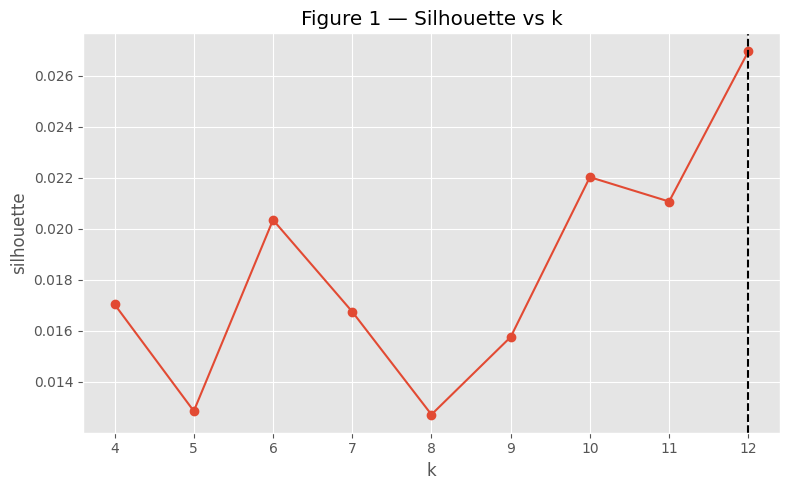

In [15]:
# Figure 1: silhouette plot
plt.figure(figsize=(8,5))
plot_df = diag_df[diag_df['variant']==best_variant].sort_values('k')
plt.plot(plot_df['k'], plot_df['silhouette'], marker='o')
plt.axvline(best_k, linestyle='--', color='black')
plt.title('Figure 1 — Silhouette vs k')
plt.xlabel('k')
plt.ylabel('silhouette')
plt.tight_layout()
plt.savefig(FIG / 'silhouette.png', dpi=180)
plt.show()


We observe that silhouette quality peaks near the selected `k`, supporting the chosen solution while maintaining reasonable cluster balance.

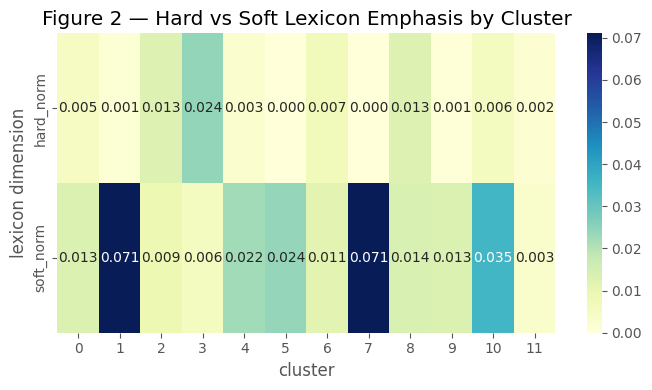

In [16]:
# Figure 2: hard vs soft lexicon heatmap
heat = df.groupby('cluster')[['hard_norm','soft_norm']].mean().sort_index()
plt.figure(figsize=(7,4))
sns.heatmap(heat.T, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Figure 2 — Hard vs Soft Lexicon Emphasis by Cluster')
plt.xlabel('cluster')
plt.ylabel('lexicon dimension')
plt.tight_layout()
plt.savefig(FIG / 'hard_soft_heatmap.png', dpi=180)
plt.show()


Cluster-level lexicon differences indicate where discourse leans toward technical qualification signals versus interpersonal and organizational framing.

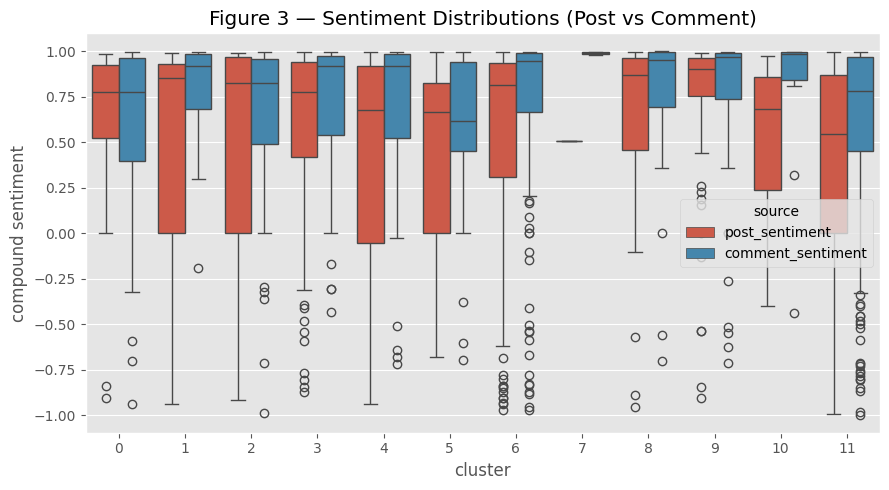

In [17]:
# Figure 3: sentiment distributions
long_sent = df[['cluster','post_sentiment','comment_sentiment']].melt(id_vars='cluster', value_vars=['post_sentiment','comment_sentiment'], var_name='source', value_name='sentiment').dropna()
plt.figure(figsize=(9,5))
sns.boxplot(data=long_sent, x='cluster', y='sentiment', hue='source')
plt.title('Figure 3 — Sentiment Distributions (Post vs Comment)')
plt.xlabel('cluster')
plt.ylabel('compound sentiment')
plt.tight_layout()
plt.savefig(FIG / 'sentiment_dist.png', dpi=180)
plt.show()


This suggests community tone can diverge from initial post tone, which stakeholders may interpret as support, correction, or heightened concern depending on cluster context.

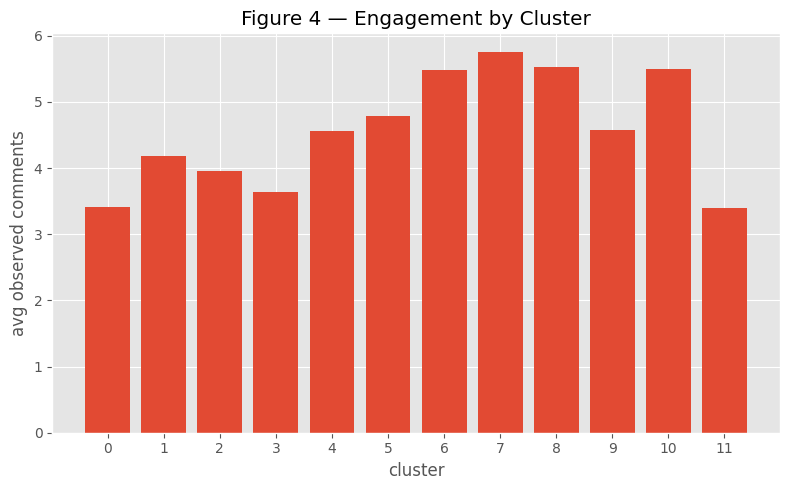

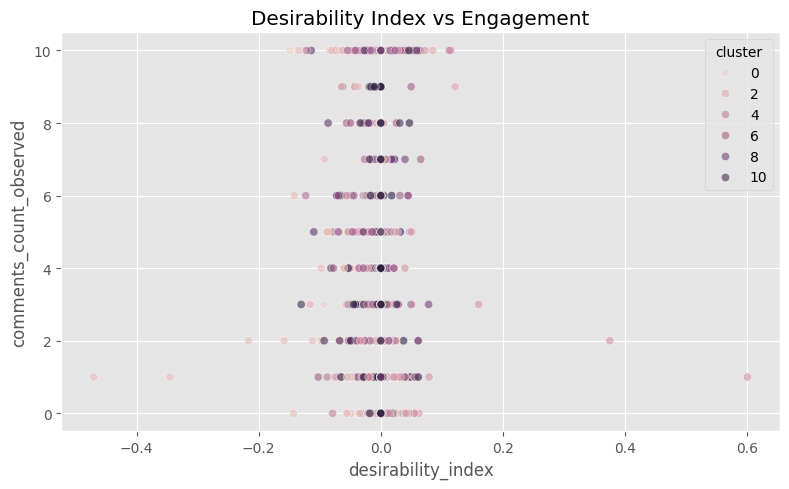

In [18]:
# Figure 4: engagement by cluster + scatter
eng = df.groupby('cluster', as_index=False)['comments_count_observed'].mean()
plt.figure(figsize=(8,5))
plt.bar(eng['cluster'].astype(str), eng['comments_count_observed'])
plt.title('Figure 4 — Engagement by Cluster')
plt.xlabel('cluster')
plt.ylabel('avg observed comments')
plt.tight_layout()
plt.savefig(FIG / 'cluster_sizes.png', dpi=180)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='desirability_index', y='comments_count_observed', hue='cluster', alpha=0.6)
plt.title('Desirability Index vs Engagement')
plt.xlabel('desirability_index')
plt.ylabel('comments_count_observed')
plt.tight_layout()
plt.savefig(FIG / 'desirability_scatter.png', dpi=180)
plt.show()


## 13) Limitations

- Reddit sampling introduces platform and self-selection bias.
- Subreddit norms and moderation culture may shape language and engagement patterns.
- PMI can be sensitive to sparse phrase frequencies and threshold choices.
- Lexicon orientation captures association in this corpus, not causal hiring dynamics.


## 14) Save Artifacts

In [19]:
# Save required artifacts with requested filenames
joblib.dump(tfidf, ART / 'tfidf_vectorizer.joblib')
joblib.dump(model, ART / 'kmeans_model.joblib')
joblib.dump(lda, ART / 'lda_model.joblib')

with open(ART / 'hard_lexicon.json','w',encoding='utf-8') as f:
    json.dump({'weights': hard_weights}, f, indent=2)
with open(ART / 'soft_lexicon.json','w',encoding='utf-8') as f:
    json.dump({'weights': soft_weights}, f, indent=2)

# enriched dataset
try:
    df.to_parquet(ART / 'final_posts_enriched.parquet', index=False)
except Exception:
    df.to_csv(ART / 'final_posts_enriched.csv', index=False)

df.to_csv(ART / 'final_posts_enriched.csv', index=False)

print('Saved artifacts in', ART)
print(sorted([p.name for p in ART.glob('*')]))


Saved artifacts in /home/frondy/code/project/Text Analytic/artifacts_refined
['cluster_summary_table.csv', 'clustering_diagnostics.csv', 'difference_from_mean_table.csv', 'final_posts_enriched.csv', 'final_posts_enriched.parquet', 'final_posts_enriched_refined.csv', 'final_posts_enriched_refined.parquet', 'hard_lexicon.json', 'kmeans_model.joblib', 'lda_model.joblib', 'lda_vectorizer.joblib', 'lexicons', 'models', 'representative_posts_table.csv', 'soft_lexicon.json', 'tables', 'tfidf_vectorizer.joblib']


## 15) Sanity Checks

In [20]:
print('Shapes:')
print('df_posts:', df_posts.shape, 'df_comments:', df_comments.shape, 'df:', df.shape)

critical = ['post_id','post_text_clean','cluster','dominant_topic','hard_score','soft_score','hard_norm','soft_norm','post_sentiment','comment_sentiment']
print('Null rates (critical):')
print(df[critical].isna().mean().sort_values())

assert df['post_id'].notna().all(), 'Null post_id detected'
assert df['cluster'].notna().all(), 'Null cluster detected'
assert df['post_text_clean'].notna().all(), 'Null cleaned text detected'

print('Model files confirmed:')
for fn in ['tfidf_vectorizer.joblib','kmeans_model.joblib','lda_model.joblib','hard_lexicon.json','soft_lexicon.json']:
    print(fn, (ART / fn).exists())

samples = df[['post_id','subreddit','cluster','dominant_topic','hard_score','soft_score','hard_norm','soft_norm','desirability_index','post_sentiment','comment_sentiment','comments_text']].sample(3, random_state=RANDOM_SEED).copy()
samples['sample_comment'] = samples['comments_text'].fillna('').str.slice(0,220)
display(samples.drop(columns=['comments_text']))

cluster_pct = df['cluster'].value_counts(normalize=True) * 100
print('Max cluster pct:', round(cluster_pct.max(),2), '%')
if cluster_pct.max() > 50:
    print('Note: largest cluster exceeds ~50%; inspect diagnostics for tradeoff rationale.')


Shapes:
df_posts: (1135, 9) df_comments: (4704, 5) df: (1135, 30)
Null rates (critical):
post_id              0.000000
post_text_clean      0.000000
cluster              0.000000
dominant_topic       0.000000
hard_score           0.000000
soft_score           0.000000
hard_norm            0.000000
soft_norm            0.000000
post_sentiment       0.000000
comment_sentiment    0.090749
dtype: float64
Model files confirmed:
tfidf_vectorizer.joblib True
kmeans_model.joblib True
lda_model.joblib True
hard_lexicon.json True
soft_lexicon.json True


,post_id,subreddit,cluster,dominant_topic,hard_score,soft_score,hard_norm,soft_norm,desirability_index,post_sentiment,comment_sentiment,sample_comment
784,1qjqt68,dataengineering,0,4,0.0,0.00000,0.0,0.000000,0.000000,0.0000,NaN,
900,1qekr0y,dataengineering,11,8,0.0,0.42895,0.0,0.013405,-0.013405,0.9423,0.8953,Fivetran is mostly just plug and play connecto...
413,1qdgvs0,dataanalysis,5,6,0.0,0.00000,0.0,0.000000,0.000000,-0.0772,0.5362,Automod prevents all posts from being displaye...


Max cluster pct: 39.65 %
